# Model Training with MLflow

The objective of this notebook is to train multiple ML models and track experiments with MLflow

Contents:
1. Load Preprocessed Data
2. MLflow Setup and Configuration
3. Train Multiple Algorithms
4. Cross-Validation
5. Model Comparison
6. Save Best Models

## Setup and Imports

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
from datetime import datetime
import mlflow
import mlflow.sklearn
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score)

warnings.filterwarnings('ignore')
import warnings
warnings.filterwarnings('ignore', category=FutureWarning, module='mlflow')

In [4]:
# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Define project paths
ROOT = Path.cwd().parent if (Path.cwd().parent / 'data').exists() else Path.cwd()
DATA_PROC = ROOT / "data" / "processed"
MODELS = ROOT / "models"
REPORTS = ROOT / "reports"
FIGS = REPORTS / "figures"

# Create directories
for p in [MODELS, FIGS]:
    p.mkdir(parents=True, exist_ok=True)

print(f"\nProject Root: {ROOT}")
print(f"Data Processed: {DATA_PROC}")
print(f"Models: {MODELS}")
print(f"Figures: {FIGS}")


Project Root: /Users/lia/Desktop/Fase1
Data Processed: /Users/lia/Desktop/Fase1/data/processed
Models: /Users/lia/Desktop/Fase1/models
Figures: /Users/lia/Desktop/Fase1/reports/figures


## Load Preprocessed Data

In [7]:
# Load training and test data
train_data = pd.read_csv(DATA_PROC / 'student_performance_train.csv')
test_data = pd.read_csv(DATA_PROC / 'student_performance_test.csv')

# Separate features and target
X_train = train_data.drop('Performance_Binary', axis=1)
y_train = train_data['Performance_Binary']
X_test = test_data.drop('Performance_Binary', axis=1)
y_test = test_data['Performance_Binary']

print(f"\n✓ Data loaded successfully")
print(f"\nTraining set:")
print(f" Features: {X_train.shape}")
print(f" Target: {y_train.shape}")
print(f" Class distribution: {y_train.value_counts().to_dict()}")

print(f"\nTest set:")
print(f" Features: {X_test.shape}")
print(f" Target: {y_test.shape}")
print(f" Class distribution: {y_test.value_counts().to_dict()}")

print(f"\nDataset Statistics:")
print(f" Total samples: {len(X_train) + len(X_test)}")
print(f" Training: {len(X_train)} ({len(X_train)/(len(X_train)+len(X_test))*100:.1f}%)")
print(f" Testing: {len(X_test)} ({len(X_test)/(len(X_train)+len(X_test))*100:.1f}%)")
print(f" Features: {X_train.shape[1]}")



✓ Data loaded successfully

Training set:
 Features: (497, 30)
 Target: (497,)
 Class distribution: {0: 276, 1: 221}

Test set:
 Features: (125, 30)
 Target: (125,)
 Class distribution: {0: 70, 1: 55}

Dataset Statistics:
 Total samples: 622
 Training: 497 (79.9%)
 Testing: 125 (20.1%)
 Features: 30


## MLflow Setup

In [8]:
# Set MLflow tracking URI
mlflow_dir = ROOT / "mlruns"
mlflow.set_tracking_uri(f"file://{mlflow_dir}")

# Set experiment name
experiment_name = "student_performance_baseline"
mlflow.set_experiment(experiment_name)

print(f"\n✓ MLflow configured")
print(f" Tracking URI: {mlflow.get_tracking_uri()}")
print(f" Experiment: {experiment_name}")
print(f" MLflow UI: Run 'mlflow ui' in project root to view experiments")

2025/10/23 11:16:20 INFO mlflow.tracking.fluent: Experiment with name 'student_performance_baseline' does not exist. Creating a new experiment.



✓ MLflow configured
 Tracking URI: file:///Users/lia/Desktop/Fase1/mlruns
 Experiment: student_performance_baseline
 MLflow UI: Run 'mlflow ui' in project root to view experiments


## Define Candidate Algorithms

In [9]:
# Define candidate models
models = {
    'Logistic Regression': {
        'model': LogisticRegression(random_state=42, max_iter=1000),
        'description': 'Simple, interpretable, works well with binary features'
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42, n_estimators=100),
        'description': 'Handles non-linear relationships, robust to overfitting'
    },
    'Gradient Boosting': {
        'model': GradientBoostingClassifier(random_state=42, n_estimators=100),
        'description': 'High performance, good for structured data'
    },
    'SVM': {
        'model': SVC(random_state=42, probability=True),
        'description': 'Effective in high-dimensional spaces'
    },
    'K-Nearest Neighbors': {
        'model': KNeighborsClassifier(),
        'description': 'Instance-based, no training phase'
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(random_state=42),
        'description': 'Interpretable, baseline for ensemble methods'
    }
}

print(f"\n✓ {len(models)} algorithms selected for comparison:")
for i, (name, info) in enumerate(models.items(), 1):
    print(f"\n{i}. {name}")
    print(f"   → {info['description']}")

print(f"\nTraining Strategy:")
print(f" • 5-fold cross-validation on training set")
print(f" • Evaluation on hold-out test set")
print(f" • All experiments tracked with MLflow")


✓ 6 algorithms selected for comparison:

1. Logistic Regression
   → Simple, interpretable, works well with binary features

2. Random Forest
   → Handles non-linear relationships, robust to overfitting

3. Gradient Boosting
   → High performance, good for structured data

4. SVM
   → Effective in high-dimensional spaces

5. K-Nearest Neighbors
   → Instance-based, no training phase

6. Decision Tree
   → Interpretable, baseline for ensemble methods

Training Strategy:
 • 5-fold cross-validation on training set
 • Evaluation on hold-out test set
 • All experiments tracked with MLflow


## Train Model with MLflow Tracking

In [17]:
# Store results
results = []
trained_models = {}

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print(f"\nStarting model training with MLflow tracking...\n")

for model_name, model_info in models.items():
    print(f"{'='*80}")
    print(f"Training: {model_name}")
    print(f"{'='*80}")
    
    model = model_info['model']
    
    # Start MLflow run with unique run name
    with mlflow.start_run(run_name=f"{model_name}_baseline") as run:
        
        # Log parameters (avoid duplicates by checking if already logged)
        try:
            mlflow.log_param("model_type", model_name)
            mlflow.log_param("algorithm", model.__class__.__name__)
            # Log model params one by one to handle any conflicts
            for param_name, param_value in model.get_params().items():
                try:
                    mlflow.log_param(param_name, param_value)
                except Exception:
                    pass  # Skip if already logged
        except Exception as e:
            print(f"Warning logging parameters: {e}")
        
        # Perform cross-validation
        print(f"→ Running 5-fold cross-validation...")
        cv_scores = cross_val_score(model, X_train, y_train, 
                                    cv=cv, scoring='accuracy', n_jobs=-1)
        
        cv_mean = cv_scores.mean()
        cv_std = cv_scores.std()
        
        print(f" ✓ CV Results: {cv_mean:.4f} (+/- {cv_std:.4f})")
        
        # Log CV metrics
        mlflow.log_metric("cv_mean_accuracy", cv_mean)
        mlflow.log_metric("cv_std_accuracy", cv_std)
        for i, score in enumerate(cv_scores):
            mlflow.log_metric(f"cv_fold_{i+1}_accuracy", score)
        
        # Train on full training set
        print(f"→ Training on full training set...")
        model.fit(X_train, y_train)
        
        # Evaluate on training set
        train_pred = model.predict(X_train)
        train_accuracy = accuracy_score(y_train, train_pred)
        print(f" ✓ Training Accuracy: {train_accuracy:.4f}")
        mlflow.log_metric("train_accuracy", train_accuracy)
        
        # Evaluate on test set
        print(f"→ Evaluating on test set...")
        test_pred = model.predict(X_test)
        test_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
        
        # Calculate metrics
        test_accuracy = accuracy_score(y_test, test_pred)
        test_precision = precision_score(y_test, test_pred)
        test_recall = recall_score(y_test, test_pred)
        test_f1 = f1_score(y_test, test_pred)
        
        print(f" ✓ Test Accuracy: {test_accuracy:.4f}")
        print(f" ✓ Test Precision: {test_precision:.4f}")
        print(f" ✓ Test Recall: {test_recall:.4f}")
        print(f" ✓ Test F1-Score: {test_f1:.4f}")
        
        # Log test metrics
        mlflow.log_metric("test_accuracy", test_accuracy)
        mlflow.log_metric("test_precision", test_precision)
        mlflow.log_metric("test_recall", test_recall)
        mlflow.log_metric("test_f1", test_f1)
        
        # Log ROC-AUC if probability available
        if test_pred_proba is not None:
            test_roc_auc = roc_auc_score(y_test, test_pred_proba)
            print(f" ✓ Test ROC-AUC: {test_roc_auc:.4f}")
            mlflow.log_metric("test_roc_auc", test_roc_auc)
        else:
            test_roc_auc = None
        
        # Log model with signature and input example (fixes warnings)
        from mlflow.models.signature import infer_signature
        signature = infer_signature(X_train, model.predict(X_train))
        input_example = X_train.iloc[:5]  # First 5 rows as example
        
        # Log model - artifact_path is a required positional argument
        mlflow.sklearn.log_model(
            sk_model=model, # First positional arg: the model itself
            artifact_path="model",
            signature=signature,
            input_example=input_example
        )
        
        # Store results
        results.append({
            'Model': model_name,
            'CV Mean': cv_mean,
            'CV Std': cv_std,
            'Train Accuracy': train_accuracy,
            'Test Accuracy': test_accuracy,
            'Test Precision': test_precision,
            'Test Recall': test_recall,
            'Test F1': test_f1,
            'Test ROC-AUC': test_roc_auc if test_roc_auc else 0.0
        })
        
        # Store trained model
        trained_models[model_name] = model
        
        print(f"{model_name} complete\n")
        
print(f"{'='*80}")
print("All models trained successfully")
print(f"{'='*80}")


Starting model training with MLflow tracking...

Training: Logistic Regression
→ Running 5-fold cross-validation...


2025/10/23 11:40:21 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


 ✓ CV Results: 0.7063 (+/- 0.0563)
→ Training on full training set...
 ✓ Training Accuracy: 0.7425
→ Evaluating on test set...
 ✓ Test Accuracy: 0.7040
 ✓ Test Precision: 0.6667
 ✓ Test Recall: 0.6545
 ✓ Test F1-Score: 0.6606
 ✓ Test ROC-AUC: 0.8284
Logistic Regression complete

Training: Random Forest
→ Running 5-fold cross-validation...


2025/10/23 11:40:25 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


 ✓ CV Results: 0.6417 (+/- 0.0386)
→ Training on full training set...
 ✓ Training Accuracy: 0.9678
→ Evaluating on test set...
 ✓ Test Accuracy: 0.7040
 ✓ Test Precision: 0.6667
 ✓ Test Recall: 0.6545
 ✓ Test F1-Score: 0.6606
 ✓ Test ROC-AUC: 0.7671
Random Forest complete

Training: Gradient Boosting
→ Running 5-fold cross-validation...


2025/10/23 11:40:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


 ✓ CV Results: 0.6680 (+/- 0.0361)
→ Training on full training set...
 ✓ Training Accuracy: 0.8048
→ Evaluating on test set...
 ✓ Test Accuracy: 0.6720
 ✓ Test Precision: 0.6207
 ✓ Test Recall: 0.6545
 ✓ Test F1-Score: 0.6372
 ✓ Test ROC-AUC: 0.8009
Gradient Boosting complete

Training: SVM
→ Running 5-fold cross-validation...
 ✓ CV Results: 0.6781 (+/- 0.0612)
→ Training on full training set...
 ✓ Training Accuracy: 0.7767
→ Evaluating on test set...
 ✓ Test Accuracy: 0.7040
 ✓ Test Precision: 0.6667
 ✓ Test Recall: 0.6545
 ✓ Test F1-Score: 0.6606


2025/10/23 11:40:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


 ✓ Test ROC-AUC: 0.7869
SVM complete

Training: K-Nearest Neighbors
→ Running 5-fold cross-validation...
 ✓ CV Results: 0.5634 (+/- 0.0275)
→ Training on full training set...
 ✓ Training Accuracy: 0.7304
→ Evaluating on test set...
 ✓ Test Accuracy: 0.6800
 ✓ Test Precision: 0.6230
 ✓ Test Recall: 0.6909
 ✓ Test F1-Score: 0.6552


2025/10/23 11:40:34 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


 ✓ Test ROC-AUC: 0.7070
K-Nearest Neighbors complete

Training: Decision Tree
→ Running 5-fold cross-validation...
 ✓ CV Results: 0.5976 (+/- 0.0328)


2025/10/23 11:40:37 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


→ Training on full training set...
 ✓ Training Accuracy: 0.9678
→ Evaluating on test set...
 ✓ Test Accuracy: 0.6480
 ✓ Test Precision: 0.6122
 ✓ Test Recall: 0.5455
 ✓ Test F1-Score: 0.5769
 ✓ Test ROC-AUC: 0.6473
Decision Tree complete

All models trained successfully


## Model Comparison and Results

In [18]:
# Create results DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Test Accuracy', ascending=False)

print(f'\nModel Performance Comparison')
print(f'{'='*80}')
print(results_df.to_string(index=False, float_format=lambda x: f'{x:.4f}'))

# Identify best model
best_model_name = results_df.iloc[0]['Model']
best_test_acc = results_df.iloc[0]['Test Accuracy']

print(f"\n{'='*80}")
print(f"BEST MODEL: {best_model_name}")
print(f"{'='*80}")
print(f" Test Accuracy: {best_test_acc:.4f} ({best_test_acc*100:.2f}%)")
print(f" CV Mean: {results_df.iloc[0]['CV Mean']:.4f}")
print(f" CV Std: {results_df.iloc[0]['CV Std']:.4f}")


Model Performance Comparison
              Model  CV Mean  CV Std  Train Accuracy  Test Accuracy  Test Precision  Test Recall  Test F1  Test ROC-AUC
Logistic Regression   0.7063  0.0563          0.7425         0.7040          0.6667       0.6545   0.6606        0.8284
      Random Forest   0.6417  0.0386          0.9678         0.7040          0.6667       0.6545   0.6606        0.7671
                SVM   0.6781  0.0612          0.7767         0.7040          0.6667       0.6545   0.6606        0.7869
K-Nearest Neighbors   0.5634  0.0275          0.7304         0.6800          0.6230       0.6909   0.6552        0.7070
  Gradient Boosting   0.6680  0.0361          0.8048         0.6720          0.6207       0.6545   0.6372        0.8009
      Decision Tree   0.5976  0.0328          0.9678         0.6480          0.6122       0.5455   0.5769        0.6473

BEST MODEL: Logistic Regression
 Test Accuracy: 0.7040 (70.40%)
 CV Mean: 0.7063
 CV Std: 0.0563


## Visualize Results


Saved visualization to: /Users/lia/Desktop/Fase1/reports/figures/model_comparison_baseline_20251023_114734.png


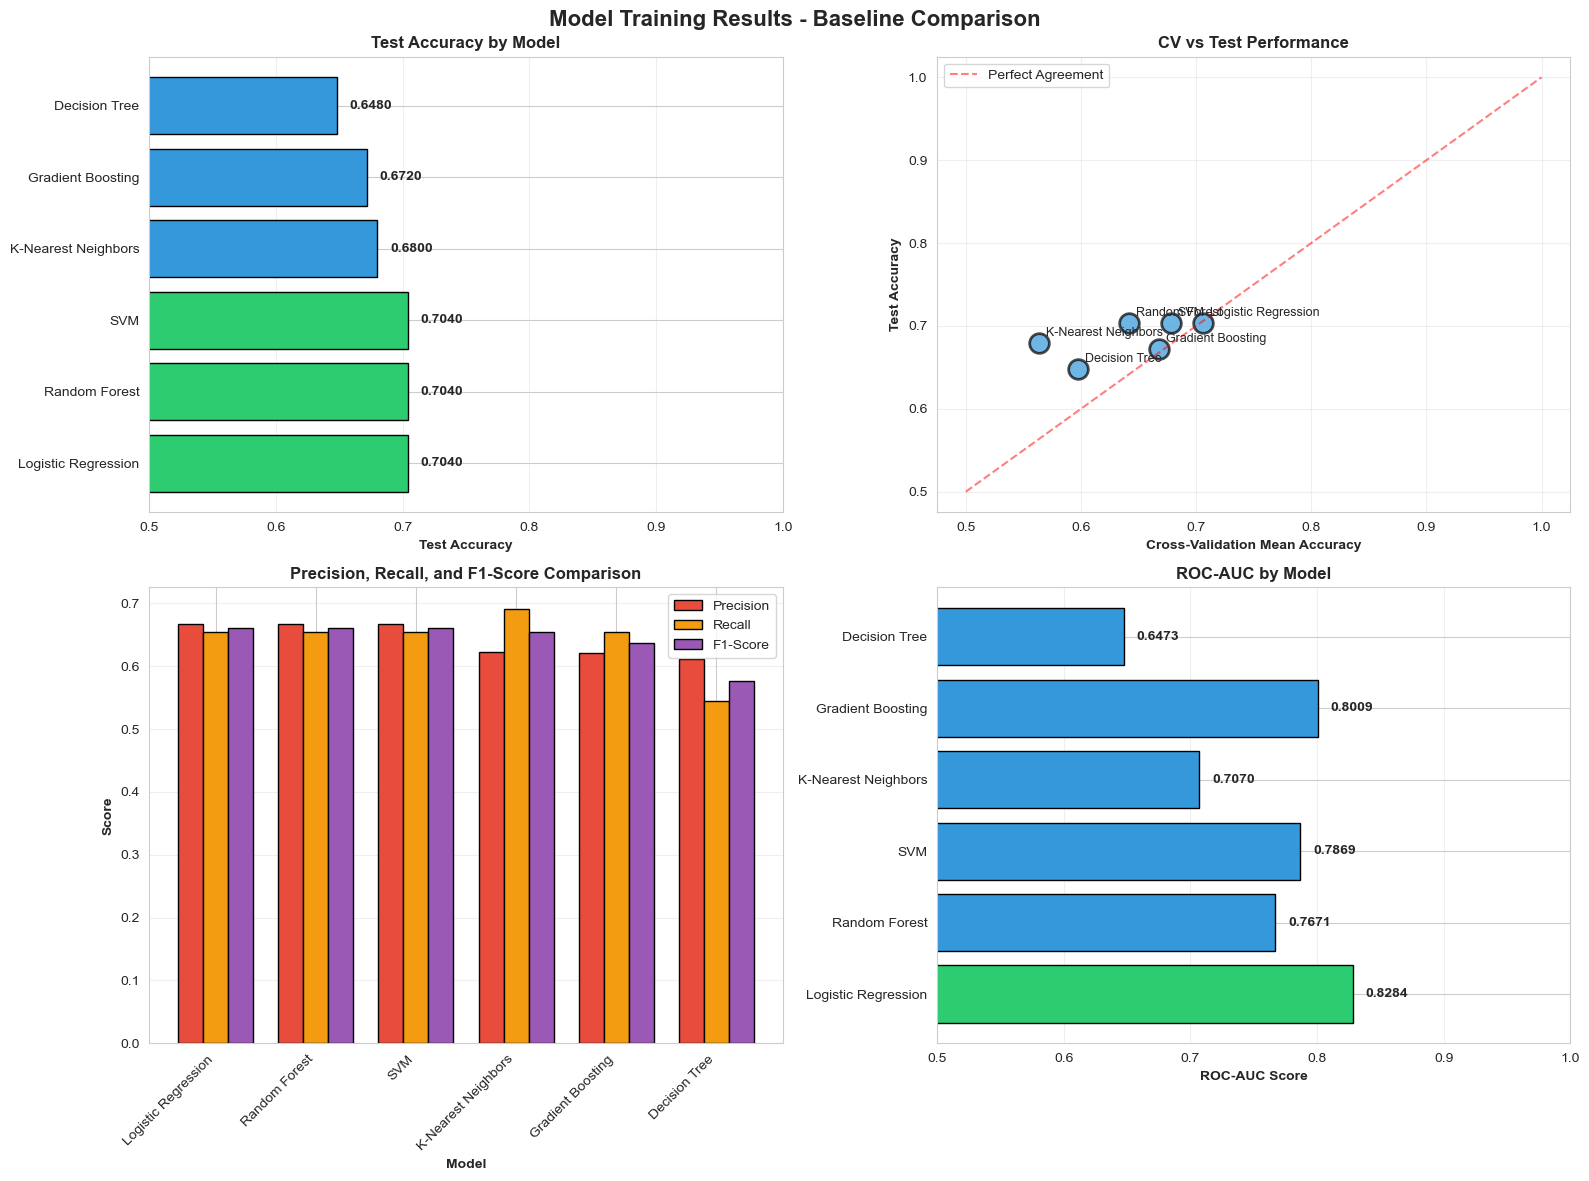

In [ ]:
# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Model Training Results - Baseline Comparison', fontsize=16, fontweight='bold')

# Test Accuracy Comparison
ax1 = axes[0, 0]
colors = ['#2ecc71' if acc == best_test_acc else '#3498db' for acc in results_df['Test Accuracy']]
bars1 = ax1.barh(results_df['Model'], results_df['Test Accuracy'], color=colors, edgecolor='black')
ax1.set_xlabel('Test Accuracy', fontweight='bold')
ax1.set_title('Test Accuracy by Model', fontweight='bold')
ax1.set_xlim([0.5, 1.0])
ax1.grid(axis='x', alpha=0.3)
for i, (bar, val) in enumerate(zip(bars1, results_df['Test Accuracy'])):
    ax1.text(val + 0.01, bar.get_y() + bar.get_height()/2, 
             f'{val:.4f}', va='center', fontweight='bold')

# CV Mean vs Test Accuracy
ax2 = axes[0, 1]
ax2.scatter(results_df['CV Mean'], results_df['Test Accuracy'], 
            s=200, c='#3498db', edgecolor='black', linewidth=2, alpha=0.7)
for i, model in enumerate(results_df['Model']):
    ax2.annotate(model, 
                (results_df['CV Mean'].iloc[i], results_df['Test Accuracy'].iloc[i]),
                xytext=(5, 5), textcoords='offset points', fontsize=9)
ax2.plot([0.5, 1.0], [0.5, 1.0], 'r--', alpha=0.5, label='Perfect Agreement')
ax2.set_xlabel('Cross-Validation Mean Accuracy', fontweight='bold')
ax2.set_ylabel('Test Accuracy', fontweight='bold')
ax2.set_title('CV vs Test Performance', fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

# Precision, Recall, F1 Comparison
ax3 = axes[1, 0]
x = np.arange(len(results_df))
width = 0.25
bars1 = ax3.bar(x - width, results_df['Test Precision'], width, label='Precision', 
                color='#e74c3c', edgecolor='black')
bars2 = ax3.bar(x, results_df['Test Recall'], width, label='Recall', 
                color='#f39c12', edgecolor='black')
bars3 = ax3.bar(x + width, results_df['Test F1'], width, label='F1-Score', 
                color='#9b59b6', edgecolor='black')
ax3.set_xlabel('Model', fontweight='bold')
ax3.set_ylabel('Score', fontweight='bold')
ax3.set_title('Precision, Recall, and F1-Score Comparison', fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(results_df['Model'], rotation=45, ha='right')
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# ROC-AUC Comparison
ax4 = axes[1, 1]
roc_data = results_df[results_df['Test ROC-AUC'] > 0]
colors_roc = ['#2ecc71' if model == best_model_name else '#3498db' 
              for model in roc_data['Model']]
bars4 = ax4.barh(roc_data['Model'], roc_data['Test ROC-AUC'], 
                 color=colors_roc, edgecolor='black')
ax4.set_xlabel('ROC-AUC Score', fontweight='bold')
ax4.set_title('ROC-AUC by Model', fontweight='bold')
ax4.set_xlim([0.5, 1.0])
ax4.grid(axis='x', alpha=0.3)
for i, (bar, val) in enumerate(zip(bars4, roc_data['Test ROC-AUC'])):
    ax4.text(val + 0.01, bar.get_y() + bar.get_height()/2, 
             f'{val:.4f}', va='center', fontweight='bold')

plt.tight_layout()

# Save figure
ts = datetime.now().strftime("%Y%m%d_%H%M%S")
out_path = FIGS / f"model_comparison_baseline_{ts}.png"
fig.savefig(out_path, dpi=300, bbox_inches='tight')
print(f"\nSaved visualization to: {out_path}")

plt.show()

## Cross-Validation Analysis


Saved CV analysis to: /Users/lia/Desktop/Fase1/reports/figures/cv_analysis_20251023_114734.png


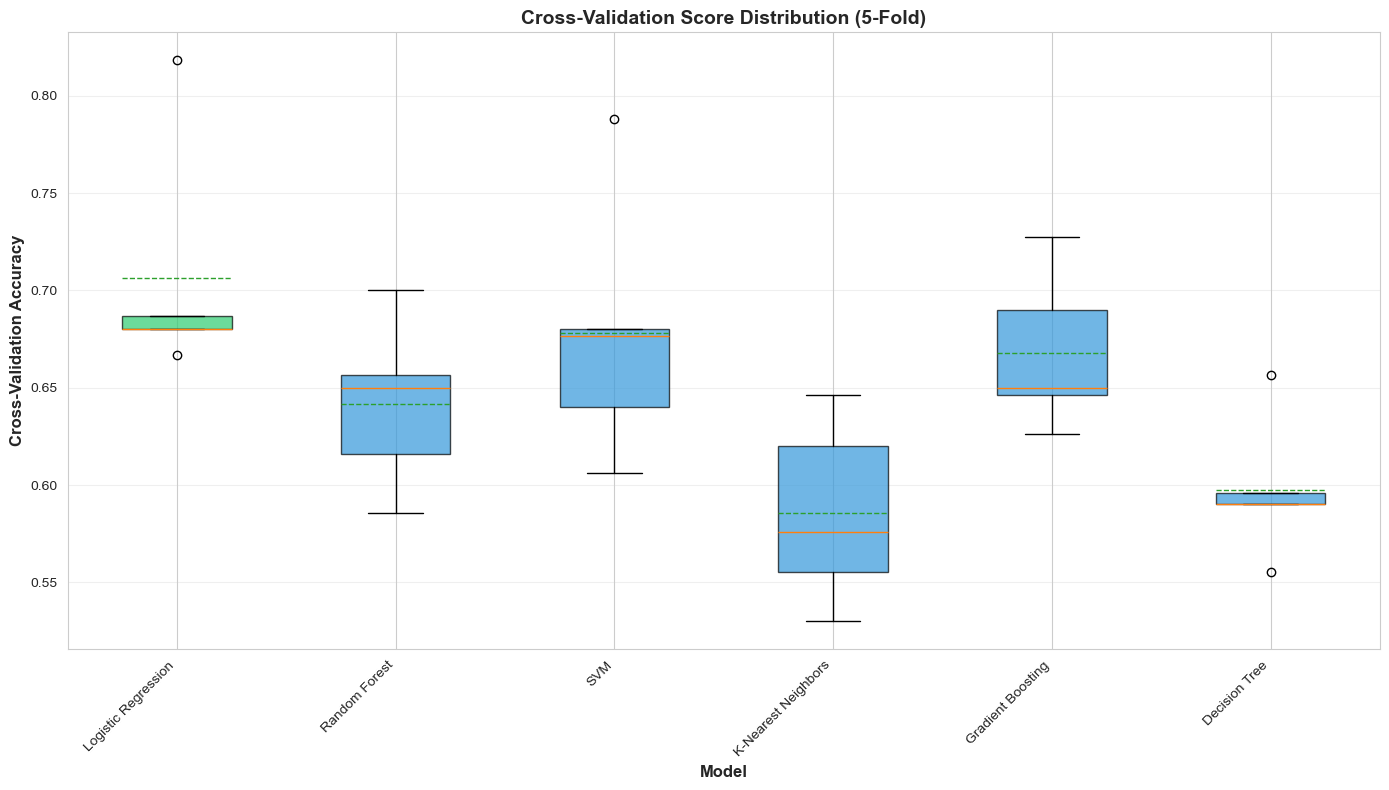

In [20]:
# Visualize CV scores for each model
fig, ax = plt.subplots(figsize=(14, 8))

cv_data = []
for model_name in results_df['Model']:
    model = models[model_name]['model']
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    cv_data.append(cv_scores)

bp = ax.boxplot(cv_data, labels=results_df['Model'], patch_artist=True,
                showmeans=True, meanline=True)

# Color the boxes
for patch, model in zip(bp['boxes'], results_df['Model']):
    if model == best_model_name:
        patch.set_facecolor('#2ecc71')
    else:
        patch.set_facecolor('#3498db')
    patch.set_alpha(0.7)

ax.set_xlabel('Model', fontweight='bold', fontsize=12)
ax.set_ylabel('Cross-Validation Accuracy', fontweight='bold', fontsize=12)
ax.set_title('Cross-Validation Score Distribution (5-Fold)', fontweight='bold', fontsize=14)
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Save figure
out_path_cv = FIGS / f"cv_analysis_{ts}.png"
fig.savefig(out_path_cv, dpi=300, bbox_inches='tight')
print(f"\nSaved CV analysis to: {out_path_cv}")

plt.show()


## Save Results and Best Model

In [21]:
# Save results to CSV
results_path = REPORTS / "model_comparison_results.csv"
results_df.to_csv(results_path, index=False)
print(f"\n✓ Results saved to: {results_path}")

# Save best model
best_model = trained_models[best_model_name]
import joblib
best_model_path = MODELS / "best_model_baseline.pkl"
joblib.dump(best_model, best_model_path)
print(f"✓ Best model saved to: {best_model_path}")

# Save all models
for model_name, model in trained_models.items():
    model_filename = model_name.lower().replace(' ', '_') + '_baseline.pkl'
    model_path = MODELS / model_filename
    joblib.dump(model, model_path)

print(f"✓ All {len(trained_models)} models saved to: {MODELS}")


✓ Results saved to: /Users/lia/Desktop/Fase1/reports/model_comparison_results.csv
✓ Best model saved to: /Users/lia/Desktop/Fase1/models/best_model_baseline.pkl
✓ All 6 models saved to: /Users/lia/Desktop/Fase1/models


## Training Summary

In [22]:
print(f"\nTRAINING STATISTICS:")
print(f" • Models trained: {len(models)}")
print(f" • Training samples: {len(X_train)}")
print(f" • Test samples: {len(X_test)}")
print(f" • Features: {X_train.shape[1]}")
print(f" • Cross-validation folds: 5")

print(f"\nBEST MODEL:")
print(f" • Algorithm: {best_model_name}")
print(f" • Test Accuracy: {best_test_acc:.4f} ({best_test_acc*100:.2f}%)")
print(f" • Test Precision: {results_df.iloc[0]['Test Precision']:.4f}")
print(f" • Test Recall: {results_df.iloc[0]['Test Recall']:.4f}")
print(f" • Test F1-Score: {results_df.iloc[0]['Test F1']:.4f}")
if results_df.iloc[0]['Test ROC-AUC'] > 0:
    print(f" • Test ROC-AUC: {results_df.iloc[0]['Test ROC-AUC']:.4f}")

print(f"\nTOP 3 MODELS:")
for i, row in results_df.head(3).iterrows():
    print(f"\n  {i+1}. {row['Model']}")
    print(f" Test Accuracy: {row['Test Accuracy']:.4f}")
    print(f" CV Mean: {row['CV Mean']:.4f} (+/- {row['CV Std']:.4f})")

print(f"\nARTIFACTS CREATED:")
print(f" ✓ {results_path.name}")
print(f" ✓ {best_model_path.name}")
print(f" ✓ {len(trained_models)} model files (.pkl)")
print(f" ✓ 2 visualizations (.png)")
print(f" ✓ MLflow experiments logged")

print(f"\nMLFLOW TRACKING:")
print(f" • Experiment: {experiment_name}")
print(f" • Runs: {len(models)}")
print(f" • Tracking URI: {mlflow.get_tracking_uri()}")
print(f" • View UI: Run 'mlflow ui' in project root")

print(f"\nNEXT STEPS:")
print(f" → Notebook 05: Hyperparameter Tuning")
print(f"  - Fine-tune top 3 models")
print(f"  - GridSearchCV with MLflow tracking")
print(f"  - Optimize hyperparameters")

print(f"\n{'='*80}")
print("Model Training Complete")
print(f"{'='*80}")


TRAINING STATISTICS:
 • Models trained: 6
 • Training samples: 497
 • Test samples: 125
 • Features: 30
 • Cross-validation folds: 5

BEST MODEL:
 • Algorithm: Logistic Regression
 • Test Accuracy: 0.7040 (70.40%)
 • Test Precision: 0.6667
 • Test Recall: 0.6545
 • Test F1-Score: 0.6606
 • Test ROC-AUC: 0.8284

TOP 3 MODELS:

  1. Logistic Regression
 Test Accuracy: 0.7040
 CV Mean: 0.7063 (+/- 0.0563)

  2. Random Forest
 Test Accuracy: 0.7040
 CV Mean: 0.6417 (+/- 0.0386)

  4. SVM
 Test Accuracy: 0.7040
 CV Mean: 0.6781 (+/- 0.0612)

ARTIFACTS CREATED:
 ✓ model_comparison_results.csv
 ✓ best_model_baseline.pkl
 ✓ 6 model files (.pkl)
 ✓ 2 visualizations (.png)
 ✓ MLflow experiments logged

MLFLOW TRACKING:
 • Experiment: student_performance_baseline
 • Runs: 6
 • Tracking URI: file:///Users/lia/Desktop/Fase1/mlruns
 • View UI: Run 'mlflow ui' in project root

NEXT STEPS:
 → Notebook 05: Hyperparameter Tuning
  - Fine-tune top 3 models
  - GridSearchCV with MLflow tracking
  - Optim

## Model Insights

In [24]:
# Calculate overfitting indicator
print(f"\nOverfitting Analysis:")
for _, row in results_df.iterrows():
    overfit = row['Train Accuracy'] - row['Test Accuracy']
    status = "⚠ Overfitting" if overfit > 0.05 else "✓ Good generalization"
    print(f"  {row['Model']}: {status} (gap: {overfit:.4f})")

# Model complexity vs performance
print(f"\nComplexity vs Performance:")
complexity_order = {
    'Logistic Regression': 1,
    'Decision Tree': 2,
    'K-Nearest Neighbors': 3,
    'SVM': 4,
    'Random Forest': 5,
    'Gradient Boosting': 6
}

for model in results_df['Model']:
    complexity = complexity_order.get(model, 0)
    acc = results_df[results_df['Model'] == model]['Test Accuracy'].values[0]
    complexity_bar = '█' * complexity
    print(f"  {model:25s} {complexity_bar:8s} → Acc: {acc:.4f}")

print(f"\nRECOMMENDATIONS:")
if best_test_acc < 0.75:
    print(f" • Consider hyperparameter tuning to improve performance")
    print(f" • Try ensemble methods or feature engineering")
elif best_test_acc < 0.85:
    print(f" • Good performance! Fine-tune the top models")
    print(f" • Consider feature selection for simpler models")
else:
    print(f" • Excellent performance!")
    print(f" • Focus on model interpretability and deployment")


Overfitting Analysis:
  Logistic Regression: ✓ Good generalization (gap: 0.0385)
  Random Forest: ⚠ Overfitting (gap: 0.2638)
  SVM: ⚠ Overfitting (gap: 0.0727)
  K-Nearest Neighbors: ⚠ Overfitting (gap: 0.0504)
  Gradient Boosting: ⚠ Overfitting (gap: 0.1328)
  Decision Tree: ⚠ Overfitting (gap: 0.3198)

Complexity vs Performance:
  Logistic Regression       █        → Acc: 0.7040
  Random Forest             █████    → Acc: 0.7040
  SVM                       ████     → Acc: 0.7040
  K-Nearest Neighbors       ███      → Acc: 0.6800
  Gradient Boosting         ██████   → Acc: 0.6720
  Decision Tree             ██       → Acc: 0.6480

RECOMMENDATIONS:
 • Consider hyperparameter tuning to improve performance
 • Try ensemble methods or feature engineering
